In [1]:
import os
import sys

from ipywidgets import interactive, IntSlider
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import polars as pl
import sqlite3
import torch

In [2]:
sys.path.append('../..')

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

Settings to force LaTeX style font within matplotlib plots

In [3]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [4]:
WL_COLUMNS = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
SYS_COLUMNS = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']

In [5]:
connection = sqlite3.connect("../../axe_data.db")
env_table = pl.read_database("SELECT * FROM environments;", connection)
run_table = pl.read_database("SELECT * FROM tunings;", connection)
ltune_table = pl.read_database("SELECT * FROM learned_tunings;", connection)
monkey_table = pl.read_database("SELECT * FROM monkey_tunings;", connection)

In [6]:
group = run_table.filter(pl.col('env_id') == 1).group_by('round').agg(
    pl.col('cost').mean().alias('mean'),
    pl.col('cost').std().alias('std'),
    pl.col('cost').count().alias('count')
).sort(by='round')
group

round,mean,std,count
i64,f64,f64,u32
0,40.339515,9.363452,100
1,42.656609,9.328867,100
2,38.657488,6.693776,100
3,37.745882,6.874189,100
4,36.78806,5.985023,100
…,…,…,…
95,30.224273,5.689548,100
96,29.794317,3.497528,100
97,29.682869,3.186583,100


# Experiment outline

1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

In [7]:
def get_data(env_id):
    env = env_table.filter(pl.col('env_id') == env_id)
    learned_tuning = ltune_table.filter(pl.col('env_id') == env_id)
    wl = Workload(*env.select(WL_COLUMNS).rows()[0])
    system = System(*env.select(SYS_COLUMNS).rows()[0])
    ltune_cost = learned_tuning.select('cost').rows()[0]
    monkey_cost = monkey_table.filter(pl.col('env_id') == env_id).select('cost').rows()[0]
    kmonkey_cost = monkey_table.filter(pl.col('env_id') == env_id).select('cost').rows()[0]
    
    group = run_table.filter(pl.col('env_id') == env_id).group_by('round').agg(
        pl.col('cost').mean().alias('mean'),
        pl.col('cost').std().alias('std'),
        pl.col('cost').count().alias('count')
    )
    group = group.with_columns(ci=(1.96 * pl.col('std') / pl.col('count').sqrt()))
    group = group.with_columns(
        ci_lower=(pl.col('mean') - pl.col('ci')),
        ci_upper=(pl.col('mean') + pl.col('ci')),
        ltune_cost=ltune_cost,
    ).sort(by='round')

    return group, wl, system, ltune_cost, monkey_cost

In [84]:
def plot_env(env_id: int = 1):
    group, wl, system, ltune_cost, monkey_cost = get_data(env_id)
    learned_tuning = ltune_table.filter(pl.col('env_id') == env_id).select('cost').rows()[0]
    monkey_cost, opt_cost = monkey_table.filter(pl.col('env_id') == env_id).select(['cost', 'kcost']).rows()[0]

    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='BO (Kap)', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=ltune_cost, xmin=0, xmax=group['round'].max(), label='AXE (Kap)', color='tab:green', linestyle='--')
    # ax.hlines(y=(ltune_cost[0] * 1.1 ), xmin=0, xmax=group['round'].max(), label='AXE (T/L)', color='black', linestyle='--')
    ax.hlines(y=monkey_cost, xmin=0, xmax=group['round'].max(), label='Monkey (T/L)', color='tab:blue', linestyle='--')
    ax.hlines(y=opt_cost, xmin=0, xmax=group['round'].max(), label='Monkey (Kap)', color='tab:orange', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload: $w_{{{env_id - 1}}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$')
    plt.show()

    return env_id, wl, system, fig, ax

In [85]:
ltune_table.filter(pl.col('env_id') == 1)

env_id,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,kap5,kap6,kap7,kap8,kap9,kap10,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,0.578876,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.118148


In [86]:
monkey_table.filter(pl.col('env_id') == 1)

env_id,bits_per_elem,size_ratio,is_leveling,cost,kcost
i64,f64,f64,i64,f64,f64
1,3.211367,6.0,1,27.830134,28.141494


In [87]:
id_widget = IntSlider(min=1, max=len(env_table), step=1)
iplot_env = interactive(plot_env, env_id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='env_id', max=15, min=1), Output()), _dom_classes=('widge…

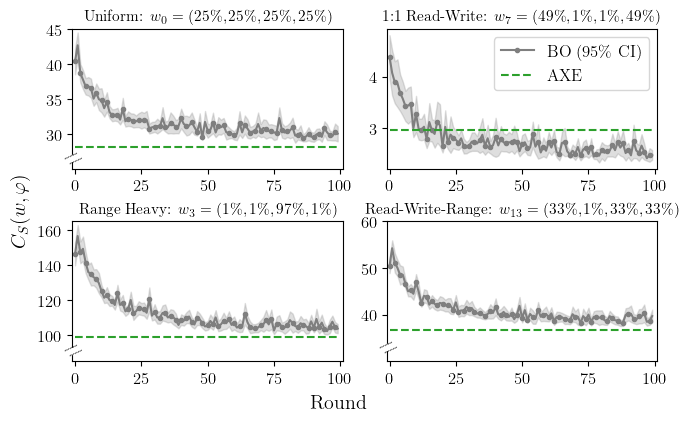

In [71]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(2*width, 2*height), constrained_layout=True)

data, wl, _, ltune_cost, _ = get_data(1)
ax = axes[0, 0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([25, 45])
ax.set_yticks([30, 35, 40, 45])
ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

data, wl, _, ltune_cost, _ = get_data(4)
ax = axes[1, 0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([85, 165])
ax.text(-4.5, 87.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 91, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Range Heavy: $w_3 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

data, wl, _, ltune_cost, _ = get_data(8)
ax = axes[0, 1]
ax.plot(data['round'], data['mean'], label='BO (95\\% CI)', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
ax.legend(loc='upper right') # , bbox_to_anchor=(1.02, 1.05))

data, wl, _, ltune_cost, _ = get_data(14)
ax = axes[1, 1]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer (95\\% CI)', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([30, 60])
ax.set_yticks([40, 50, 60])
ax.text(-4.5, 31.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 33, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Read-Write-Range: $w_{{13}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
# save_fig(fig, 'bo_comparison_with_init.pdf')
# save_fig(fig, 'bo_comparison.pdf')
plt.show()

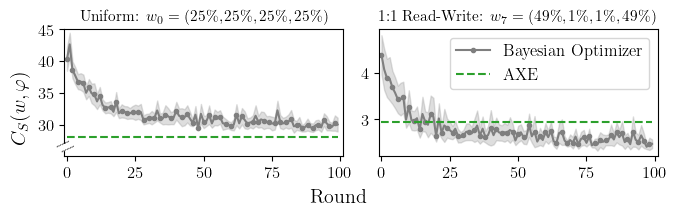

In [16]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*width, 1*height), constrained_layout=True)

data, wl, ltune_cost, _, _ = get_data(1)
ax = axes[0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([25, 45])
ax.set_yticks([30, 35, 40, 45])
ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
# ax.set_title(f'Uniform: $w_0$', fontsize=12)

data, wl, ltune_cost, _, _ = get_data(8)
ax = axes[1]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
ax.legend(loc='upper right') # , bbox_to_anchor=(1.02, 1.05))
# ax.set_title(f'1:1 Read-Write: $w_7$', fontsize=12)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
# save_fig(fig, 'bo_comparison_with_init.pdf')
plt.show()

# Analyzing Trends

1. The first graph is a simple cutoff, we count the rounds up until Bayesian Optimization provides a configuration that is lower in expected cost than the design provided by LTune.

2. TODO: Come up with window criteria

In [ ]:
# sql_query = """
#     SELECT
#         t.env_id,
#         t.trial,
#         MIN(t.round) as min_round
#     FROM tunings t
#     INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
#     WHERE t.cost < lt.cost
#     GROUP BY t.env_id, t.trial;
#     """
# df = pd.read_sql(sql_query, connection)
# potential_total = pd.read_sql("SELECT COUNT(*) FROM (SELECT DISTINCT env_id, trial FROM tunings)", connection).values[0][0]
# data = df['min_round'].values
# data = np.concatenate([data, [float('inf') for _ in range(potential_total - len(data))]])

# fig, ax = plt.subplots()
# ax.ecdf(data, label="CDF", complementary=False)
# ax.set_xlabel("BO Rounds")
# ax.set_ylabel("Probability of Occurence")
# ax.set_title("Rounds Once BO Outperforms LTune")
# ax.grid()
# plt.show()

In [17]:
def plot_windowing_cdf(window_size=1):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    fig, ax = plt.subplots()
    ax.ecdf(data, label="CDF", complementary=False)
    ax.set_xlabel("Round $i$")
    ax.set_ylabel(f"$P[\\omega_{{{window_size},i}}]$", size=12)
    ax.grid()
    plt.show()

    return fig, ax, data

In [19]:
# window_size_widget = IntSlider(min=1, max=10, step=1)
# iplot_cdf = interactive(plot_windowing_cdf, window_size=window_size_widget)
# iplot_cdf

In [29]:
for (x, y), group in run_table.group_by(['env_id', 'trial']):
    print(group)
    break

shape: (100, 27)
┌───────┬────────┬───────┬───────┬───┬───────┬───────┬───────┬───────────┐
│ idx   ┆ env_id ┆ trial ┆ round ┆ … ┆ kap17 ┆ kap18 ┆ kap19 ┆ cost      │
│ ---   ┆ ---    ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---       │
│ i64   ┆ i64    ┆ i64   ┆ i64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64       │
╞═══════╪════════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═══════════╡
│ 87401 ┆ 9      ┆ 74    ┆ 0     ┆ … ┆ 4.0   ┆ 28.0  ┆ 21.0  ┆ 70.995162 │
│ 87402 ┆ 9      ┆ 74    ┆ 1     ┆ … ┆ 11.0  ┆ 28.0  ┆ 21.0  ┆ 72.536257 │
│ 87403 ┆ 9      ┆ 74    ┆ 2     ┆ … ┆ 6.0   ┆ 29.0  ┆ 13.0  ┆ 69.16281  │
│ 87404 ┆ 9      ┆ 74    ┆ 3     ┆ … ┆ 18.0  ┆ 24.0  ┆ 12.0  ┆ 70.547146 │
│ 87405 ┆ 9      ┆ 74    ┆ 4     ┆ … ┆ 6.0   ┆ 29.0  ┆ 14.0  ┆ 69.526673 │
│ …     ┆ …      ┆ …     ┆ …     ┆ … ┆ …     ┆ …     ┆ …     ┆ …         │
│ 87496 ┆ 9      ┆ 74    ┆ 95    ┆ … ┆ 13.0  ┆ 2.0   ┆ 24.0  ┆ 55.983831 │
│ 87497 ┆ 9      ┆ 74    ┆ 96    ┆ … ┆ 7.0   ┆ 9.0   ┆ 23.0  ┆ 50.647227 │
│ 87498 

In [38]:
ltune_table.filter(pl.col('env_id') == 9)['cost'][0]

50.63399455518505

In [41]:
group['cost'].le(ltune_table.filter(pl.col('env_id') == 9)['cost'][0])

cost
bool
false
false
false
false
false
…
false
false
false


In [28]:
def get_window_data(window_range=range(1,5)):
    data = []
    for window_size in window_range:
        row = []
        for (env_id, trial), group in run_table.group_by(['env_id', 'trial']):
            valid_idx = group['cost'].le(ltune_table.filter(pl.col('env_id') == env_id)['cost'][0]) \
                             .rolling_min(window_size).min().fillna(0) \
                             .to_numpy().nonzero()[0]
            row.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
        data.append(row)

    return data

data = get_window_data(range(1, 5))

AttributeError: 'Series' object has no attribute 'rolling'

In [ ]:
plt.rcParams.update({'font.size': 14})
    
fig, ax = plt.subplots(figsize=(1*width, 0.8*height))
linestyles = ('solid', '-.', 'dashed', 'dotted')
ax.plot(np.NaN, np.NaN, '', color='none', label=r'Window $\rho$:')
for window in range(1, 5):
    ax.ecdf(data[window - 1], label=window, complementary=False, rasterized=True, linewidth=1, linestyle=linestyles[window - 1])

ax.set_xlabel("Round $i$", fontsize=16)
ax.set_ylabel(r"$P[ \psi_\rho^i ]$", fontsize=16)
ax.set_xlim([0, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0, 1])
# ax.legend(title=r"Window $\rho$", fontsize=11, loc='upper left', bbox_to_anchor=(-0.02,1.03), labelspacing=0.1)
leg = ax.legend(loc='upper center', ncols=5, bbox_to_anchor=(0.5,1.40), handletextpad=0.5, handlelength=1, labelspacing=0.1, columnspacing=0.6)

for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(-5)

ax.grid()
plt.show()
# save_fig(fig, 'bo_window_cdf.pdf')

In [ ]:
run_table['cum_sum'] = run_table.groupby(['env_id', 'trial'])['cost'].cumsum()
df = run_table.join(ltune_table.cost, on='env_id', rsuffix='_axe')
df = df.join(env_table.writes, on='env_id')
df['delta_regret'] = df['cum_sum'] - df['cost_axe']
df['norm_delta_cost'] = (df['cost'] - df['cost_axe']) / df['cost_axe']

wl_categories = (
    {1: 0}
    | {i: 1 for i in range(2, 6)}
    | {i: 2 for i in range(6, 12)}
    | {i: 3 for i in range(12, 16)}
)
df['wl_type'] = df['env_id'].replace(wl_categories)

min_table = df.loc[df.groupby(['env_id', 'trial']).norm_delta_cost.idxmin()]